### 越本さんの測光誤差の推定を追う。

In [30]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy import integrate
import matplotlib.pyplot as pl
import matplotlib as mpl
import pysynphot as S
mpl.rc('font',**{'family':'serif','serif':['Palatino']})
%config InlineBackend.figure_formats = {'png', 'retina'}
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 15

In [31]:
def blackbody(WaveLength, T): 
    #"""Blackbody as a function of wavelength (nm) and temperature (K). 
    #return (photons/s/m^2/str)"""
    from scipy.constants import h,k,c
    wl = WaveLength*1.0e-09 #converting [nm] -> [m]
    photons = 2*c*pow(wl,-4)/(np.exp(h*c/(k*wl*T))-1)
    return photons
class Design_20191111():
    "Optical Design in [mm]"
    def __init__(self,obj):
        self.obj = obj
        "Distances between each boundary"
        self.dist_M_L1        = 2967.071
        self.dist_L1_L2       = 289.248
        self.dist_L2_L3       = 129.766
        self.dist_L3_L4       = 243.54
        self.dist_L4_Window   = 11
        self.dist_Window_CW   = 42.20
        self.dist_CW_F1       = 14.21
        self.dist_F1_F2       = 7.70
        self.dist_F2_Detector = 2.41+1.60+6.88
        "Thickness"
        self.thick_L1         = 44.54
        self.thick_L2         = 17.72
        self.thick_L3         = 19.97
        self.thick_L4         = 18.99
        self.thick_Window     = 9
        self.thick_CW         = 6
        self.thick_F1         = 6
        self.thick_F2         = 6
        "Radius"
        self.radi_Mirror    = 900.098
        self.radi_Hole      = 400  ## temporary value. Hole radius is 
        self.radi_L1S1      = 232.5
        self.radi_L1S2      = 225
        self.radi_L2S1      = 153.73
        self.radi_L2S2      = 136.487
        self.radi_L3S1      = 135.001
        self.radi_L3S2      = 135
        self.radi_L4S1      = 100
        self.radi_L4S2      = 100
        self.radi_WindowS1  = 94.9
        self.radi_WindowS2  = 92.8
        self.radi_CWS1      = 110.2/np.sqrt(2)
        self.radi_CWS2      = 108.4/np.sqrt(2)
        self.radi_F1S1      = 71.6
        self.radi_F1S2      = 70.7
        self.radi_F2S1      = 66.9
        self.radi_F2S2      = 65.5
        self.radi_Detector  = 86.83/np.sqrt(2)
class Config(Design_20191111):
    def __init__(self,obj):
        super().__init__(obj)
        if self.obj == "Mirror":
            self.distance = self.dist_M_L1+self.thick_L1+self.dist_L1_L2+self.thick_L2+self.dist_L2_L3\
                            +self.thick_L3+self.dist_L3_L4+self.thick_L4+self.dist_L4_Window+self.thick_Window\
                            +self.dist_Window_CW+self.thick_CW+self.dist_CW_F1+self.thick_F1+self.dist_F1_F2+self.thick_F2+self.dist_F2_Detector
            self.radius = self.radi_Mirror
            self.angle = np.arctan(self.radius/self.distance)
        if self.obj == "Hole":
            self.distance = self.dist_M_L1+self.thick_L1+self.dist_L1_L2+self.thick_L2+self.dist_L2_L3\
                            +self.thick_L3+self.dist_L3_L4+self.thick_L4+self.dist_L4_Window+self.thick_Window\
                            +self.dist_Window_CW+self.thick_CW+self.dist_CW_F1+self.thick_F1+self.dist_F1_F2+self.thick_F2+self.dist_F2_Detector
            self.radius = self.radi_Hole
            self.angle = np.arctan(self.radius/self.distance)
        if self.obj == "CB":
            self.distance = self.dist_Window_CW+self.thick_CW+self.dist_CW_F1+self.thick_F1+self.dist_F1_F2+self.thick_F2+self.dist_F2_Detector - 4.00
            self.radius   = 131.2/2 #Window has a square shape. Side length...
            self.angle = np.arctan(self.radius/self.distance)
        if self.obj == "CW":
            self.distance = self.dist_CW_F1+self.thick_F1+self.dist_F1_F2+self.thick_F2+self.dist_F2_Detector
            self.radius   = 110.2/2
            self.angle    = np.arctan(self.radius/self.distance)

#### 立体角の計算

In [32]:
"Solid Angle"
SA_Hole   = 2*np.pi*(1-np.cos(Config("Hole").angle))
SA_Mirror = 2*np.pi*(1-np.cos(Config("Mirror").angle))-SA_Hole
SA_CB = 4*np.arcsin(np.sin(Config("CB").angle)**2) #Square shape
SA_Barrel = SA_CB - SA_Mirror - SA_Hole
print('Mirror     : ', '{:.4f}'.format(SA_Mirror), ' (str)')
print('Hole       : ', '{:.4f}'.format(SA_Hole), ' (str)\n')
print('-------No considering light bending------------')
print('incident angle: ', '{:.4f}'.format(Config("CB").angle/np.pi*180), '(deg)')
print('Cold Baffle   : ', '{:.4f}'.format(SA_CB), ' (str)')
print('Barrel        : ', '{:.4f}'.format(SA_Barrel), ' (str)')
print('-------Considering light bending------------')
#36.3931 (deg)
#38.0171941703629
SA_CB = 4*np.arcsin(np.sin(38.0171941703629*np.pi/180)**2)
SA_Barrel = SA_CB - SA_Mirror - SA_Hole
print('incident angle: ', '{:.4f}'.format(38.0171941703629),'(deg)')
print('Cold Baffle   : ', '{:.4f}'.format(SA_CB),     ' (str)')
print('Barrel        : ', '{:.4f}'.format(SA_Barrel), ' (str)')

Mirror     :  0.1317  (str)
Hole       :  0.0337  (str)

-------No considering light bending------------
incident angle:  36.3931 (deg)
Cold Baffle   :  1.4390  (str)
Barrel        :  1.2735  (str)
-------Considering light bending------------
incident angle:  38.0172 (deg)
Cold Baffle   :  1.5563  (str)
Barrel        :  1.3908  (str)


In [33]:
# Configuration
WVC_best = 1     # 2.3mm or 10.0mm
airmass_best = 1 # 1.0 or 2.0

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


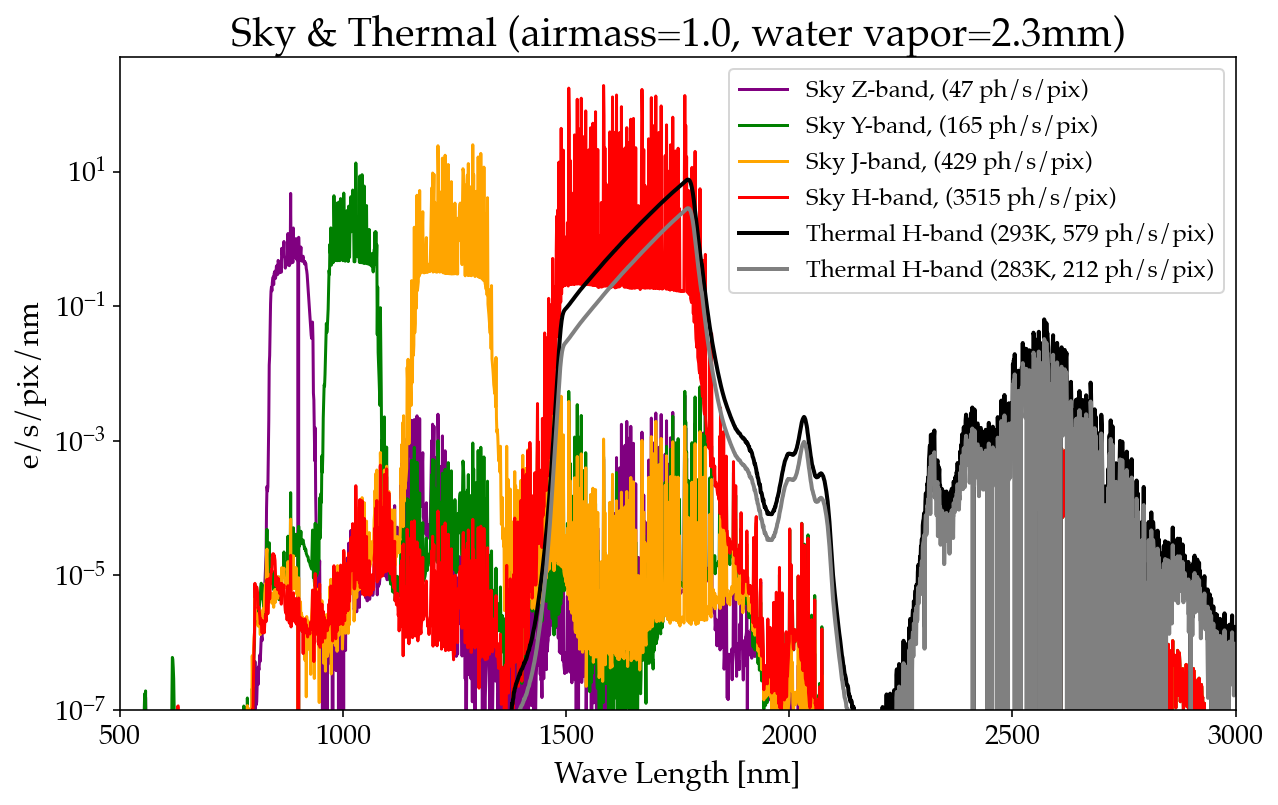

In [34]:
AR = np.loadtxt("files/AR_coating.dat")
AR14_6 = np.array(AR.T[1]*0.01)**10 # AR coating of L1+L2+L3+L4+Window
AR14_6_m = interp1d(AR.T[0],AR14_6,fill_value=(1,1),bounds_error=False)
QE = np.load("files/VISTA_QE+H4RG_NTE_original.npy") # Quantum Efficiency 
QE_m = interp1d(QE[0],QE[1],fill_value="extrapolate" )
if WVC_best==1 and airmass_best==1:
    sky = np.load("files/cp_skybg_zm_23_10_ph_bin.npy") #(photons/s/arcsec^2/nm/m^2)
if WVC_best==1 and airmass_best==0:
    sky = np.load("files/cp_skybg_zm_23_20_ph_bin.npy") #(photons/s/arcsec^2/nm/m^2)
if WVC_best==0 and airmass_best==1:
    sky = np.load("files/cp_skybg_zm_100_10_ph_bin.npy") #(photons/s/arcsec^2/nm/m^2)
if WVC_best==0 and airmass_best==0:
    sky = np.load("files/cp_skybg_zm_100_20_ph_bin.npy") #(photons/s/arcsec^2/nm/m^2)
sky_m = interp1d(sky[0],sky[1],fill_value="extrapolate")
Ref_Mir = np.loadtxt("files/Reflectance_Mirror.dat") # Reflectance of PRIME mirror
RefMir_m = interp1d(Ref_Mir.T[0]*100,Ref_Mir.T[1]*0.01,fill_value="extrapolate")
Vega = np.loadtxt("files/Vega_stis_008.dat",comments="#") # [erg/s/cm2/A]
NM = Vega.T[0]*0.1 
def erg_cm2_A_to_ph_m2_nm(nm,spectrum):
    h_cons = 6.62607876*1e-27      # [erg s]
    c_cons = 2.99792458*1e+8       # [m/s]
    hc = h_cons*c_cons             # [erg m]
    hv = hc/(nm*1e-9)              # [erg/photons]         
    photons = spectrum*10/hv*1e+4 # [photons/s/m2/nm]
    return photons
photons = erg_cm2_A_to_ph_m2_nm(NM,Vega.T[1])
if(1):
    transky = np.load("files/cp_trans_zm_23_10_ph_bin.npy")
if(0):
    transky = np.load("files/cp_trans_zm_100_20_ph_bin.npy")
transky_m = interp1d(transky[0],transky[1],fill_value="extrapolate")
Vega_m = interp1d(NM,photons,fill_value="extrapolate") #[photons/s/m^2/nm]
SUN = np.loadtxt("files/Sun_stis_002.dat")
photons_sun = erg_cm2_A_to_ph_m2_nm(SUN.T[0]*0.1,SUN.T[1])
Sun_m = interp1d(0.1*SUN.T[0],photons_sun,fill_value="extrapolate") #[photons/s/m^2/nm]

pixel_pitch = 1.0e-10 # [m^2]
FOV         = 0.25    #[arcsec/pixel]
Mirror_Area = np.pi*(0.9**2-(Config("Hole").radius*0.001)**2) #[m^2]
# Filter Configuration
from scipy import interp, arange, exp
Filters = np.load("files/PRIME_filters_20210803.npy")
CW = np.load("files/PRIME_CWfilter_20210803.npy")
Z_m  = interp1d(Filters[0],Filters[1],fill_value=(1,1),bounds_error=False)
Y_m  = interp1d(Filters[0],Filters[2],fill_value=(1,1),bounds_error=False)
J_m  = interp1d(Filters[0],Filters[3],fill_value=(1,1),bounds_error=False)
H_m  = interp1d(Filters[0],Filters[4],fill_value=(1,1),bounds_error=False)
CW_m = interp1d(CW[0],CW[1],fill_value=(1,1),bounds_error=False)
if(1):
    wl = np.arange(500,3001,1)
    fig,ax = pl.subplots(figsize=(10,6))
    if WVC_best==1 and airmass_best==1:
        ax.set_title("Sky & Thermal (airmass=1.0, water vapor=2.3mm)",fontsize=20)
    if WVC_best==1 and airmass_best==0:
        ax.set_title("Sky & Thermal (airmass=2.0, water vapor=2.3mm)",fontsize=20)
    if WVC_best==0 and airmass_best==1:
        ax.set_title("Sky & Thermal (airmass=1.0, water vapor=10.0mm)",fontsize=20)
    if WVC_best==0 and airmass_best==0:
        ax.set_title("Sky & Thermal (airmass=2.0, water vapor=10.0mm)",fontsize=20)
    pl.plot(wl,Z_m(wl)*CW_m(wl)*sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area,color="purple"
            ,label="Sky Z-band, ("+str("{:.0f}".format(np.sum(Z_m(wl)*CW_m(wl)*sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area)))+" ph/s/pix)")
    pl.plot(wl,Y_m(wl)*CW_m(wl)*sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area,color="green"
            ,label="Sky Y-band, ("+str("{:.0f}".format(np.sum(Y_m(wl)*CW_m(wl)*sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area)))+" ph/s/pix)")
    pl.plot(wl,J_m(wl)*CW_m(wl)*sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area,color="orange"
            ,label="Sky J-band, ("+str("{:.0f}".format(np.sum(J_m(wl)*CW_m(wl)*sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area)))+" ph/s/pix)")
    pl.plot(wl,H_m(wl)*CW_m(wl)*sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area,color="red"
            ,label="Sky H-band, ("+str("{:.0f}".format(np.sum(H_m(wl)*CW_m(wl)*sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area)))+" ph/s/pix)")
    dm = 1.0e-09 #dlambda
    pl.plot(wl,blackbody(wl,293)*dm*(SA_CB)*pixel_pitch*QE_m(wl)*H_m(wl)*CW_m(wl),color="k",lw=2
            ,label="Thermal H-band (293K, "+str("{:.0f}".format(np.sum(blackbody(wl,293)*dm*SA_Barrel*pixel_pitch*QE_m(wl)*H_m(wl)*CW_m(wl))))+" ph/s/pix)")
    pl.plot(wl,blackbody(wl,283)*dm*(SA_CB)*pixel_pitch*QE_m(wl)*H_m(wl)*CW_m(wl),color="gray",lw=2
            ,label="Thermal H-band (283K, "+str("{:.0f}".format(np.sum(blackbody(wl,283)*dm*SA_Barrel*pixel_pitch*QE_m(wl)*H_m(wl)*CW_m(wl))))+" ph/s/pix)")
    pl.legend(fontsize=12)
    pl.yscale("log")
    pl.ylim(10**-7,500)
    pl.xlim(500,3000)
    ax.set_xlabel("Wave Length [nm]")
    ax.set_ylabel("e/s/pix/nm")
    fig.savefig("Sky_Thermal.eps",bbox_inches="tight")
    pl.show()

In [35]:
VEGA = S.Vega
seeing = 1.4 # ["/FWHM]
pix_scale = 0.5**2 #["/pix]
PSF = np.pi*(0.5*seeing)**2/pix_scale #[pix]
dm = 1e-9 # [nm]
Temp = 280

wl = np.arange(500,3001,1)
Sky_cont_H   = sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area*H_m(wl)*CW_m(wl)           # [photons/s/pix]
Sky_cont_J   = sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area*J_m(wl)*CW_m(wl)           # [photons/s/pix]
Sky_cont_Y   = sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area*Y_m(wl)*CW_m(wl)           # [photons/s/pix]
Sky_cont_Z   = sky_m(wl)*QE_m(wl)*AR14_6_m(wl)*FOV*Mirror_Area*Z_m(wl)*CW_m(wl)           # [photons/s/pix]
Therm_cont_H = blackbody(wl,Temp)*dm*(SA_CB)*pixel_pitch*QE_m(wl)*H_m(wl)*CW_m(wl)         # [photons/s/pix]
Therm_cont_J = blackbody(wl,Temp)*dm*(SA_CB)*pixel_pitch*QE_m(wl)*J_m(wl)*CW_m(wl)         # [photons/s/pix]
Therm_cont_Y = blackbody(wl,Temp)*dm*(SA_CB)*pixel_pitch*QE_m(wl)*Y_m(wl)*CW_m(wl)         # [photons/s/pix]
Therm_cont_Z = blackbody(wl,Temp)*dm*(SA_CB)*pixel_pitch*QE_m(wl)*Z_m(wl)*CW_m(wl)         # [photons/s/pix]
Vega0_cont_H = Vega_m(wl)*transky_m(wl)*RefMir_m(wl)*Mirror_Area*QE_m(wl)*AR14_6_m(wl)*H_m(wl)*CW_m(wl) # [photons/s]
Vega0_cont_J = Vega_m(wl)*transky_m(wl)*RefMir_m(wl)*Mirror_Area*QE_m(wl)*AR14_6_m(wl)*J_m(wl)*CW_m(wl) # [photons/s]
Vega0_cont_Y = Vega_m(wl)*transky_m(wl)*RefMir_m(wl)*Mirror_Area*QE_m(wl)*AR14_6_m(wl)*Y_m(wl)*CW_m(wl) # [photons/s]
Vega0_cont_Z = Vega_m(wl)*transky_m(wl)*RefMir_m(wl)*Mirror_Area*QE_m(wl)*AR14_6_m(wl)*Z_m(wl)*CW_m(wl) # [photons/s]
Sun_cont_H = Sun_m(wl)*transky_m(wl)*RefMir_m(wl)*Mirror_Area*QE_m(wl)*AR14_6_m(wl)*H_m(wl)*CW_m(wl) # [photons/s]
Sun_cont_J = Sun_m(wl)*transky_m(wl)*RefMir_m(wl)*Mirror_Area*QE_m(wl)*AR14_6_m(wl)*J_m(wl)*CW_m(wl) # [photons/s]
Sun_cont_Y = Sun_m(wl)*transky_m(wl)*RefMir_m(wl)*Mirror_Area*QE_m(wl)*AR14_6_m(wl)*Y_m(wl)*CW_m(wl) # [photons/s]
Sun_cont_Z = Sun_m(wl)*transky_m(wl)*RefMir_m(wl)*Mirror_Area*QE_m(wl)*AR14_6_m(wl)*Z_m(wl)*CW_m(wl) # [photons/s]

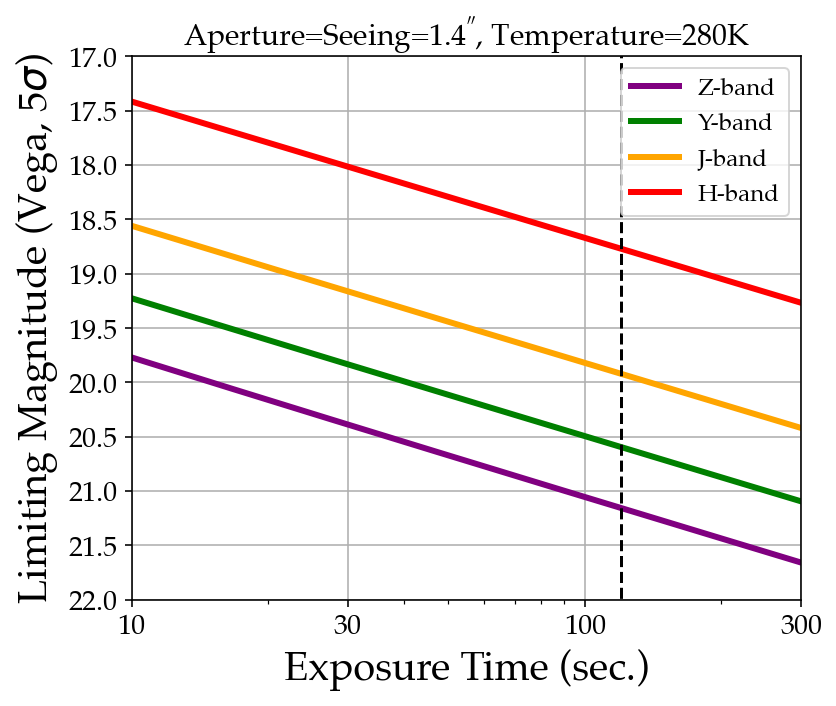

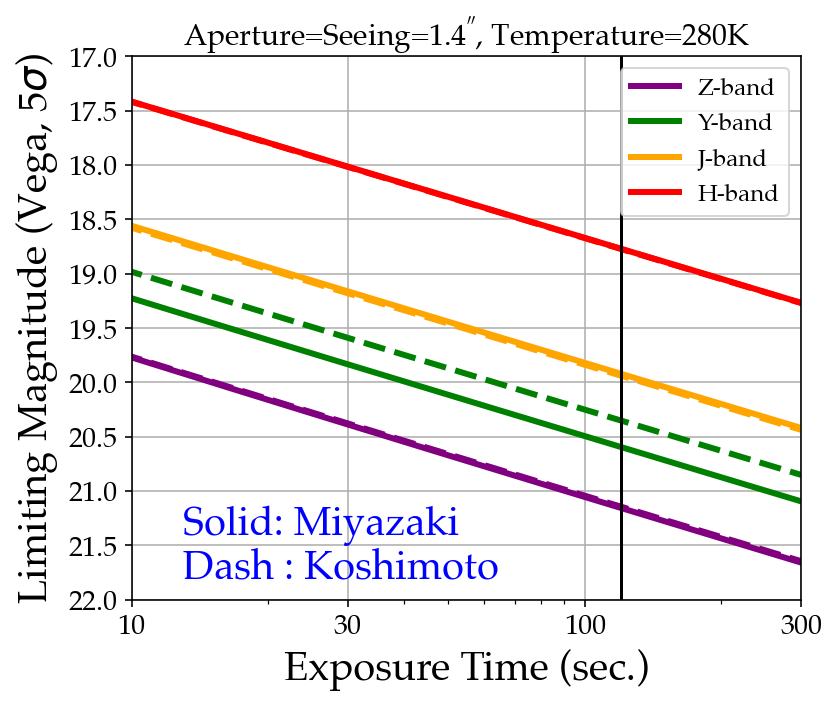

In [38]:
Mag0  = np.array([np.sum(Vega0_cont_Z),np.sum(Vega0_cont_Y)
                  ,np.sum(Vega0_cont_J),np.sum(Vega0_cont_H)]) #[ph/s]
Noise = np.array([np.sum(Sky_cont_Z+Therm_cont_Z)
                  ,np.sum(Sky_cont_Y+Therm_cont_Y)
                  ,np.sum(Sky_cont_J+Therm_cont_J)
                  ,np.sum(Sky_cont_H+Therm_cont_H)]) #[ph/s]
Sun0  = np.array([np.sum(Sun_cont_Z),np.sum(Sun_cont_Y)
                  ,np.sum(Sun_cont_J),np.sum(Sun_cont_H)]) #[ph/s]

DM = -5*np.log10(8300/10)
mag0H_Sun = 3.268    # 太陽の絶対等級 in H
mag0_Sun = np.array([mag0H_Sun,mag0H_Sun,mag0H_Sun,3.268]) # 太陽の絶対等級
mag0H_KF06 = -3.211; # KF06の絶対等級 in H
mag_sun = np.array([])
for i in range(4):
    mag_ap_sun  =  -2.5*np.log10(Sun0[i]/Mag0[i]) # Apparent Magnitude of Sun
    dmag_sun    = mag0H_Sun - mag_ap_sun             # 太陽の距離指数
    mag         = mag_ap_sun + dmag_sun - DM
    mag_sun     = np.append(mag_sun,mag)

TH = 5 # Detection Threshold
TH2 = TH**2
time = np.logspace(0,np.log10(1000),1000)
EXPT = np.array([])
Mag = np.array([])
i=0
Limit_mag=np.array([])
for elec_vega,elec_noise in zip(Mag0,Noise):
    t_   = np.array([])
    mag_ = np.array([])
    for expt in time:
        elec_vega0  = elec_vega*expt
        elec_noise0 = elec_noise*expt*PSF
        elec_th = 0.5*TH2*(1+np.sqrt(1+4*elec_noise0/TH2))*2 #because 50% of flux is in FWHM.
        limit_mag = -2.5*np.log10(elec_th/elec_vega0)
        t_   = np.append(t_,expt)
        mag_ = np.append(mag_,limit_mag)
    Limit_mag = np.hstack((Limit_mag,mag_))
    i = i+1
Limit_mag = Limit_mag.reshape(4,1000)
if(1):
    fig,ax = pl.subplots(figsize=(6,5))
    colors = ["purple","green","orange","red"]
    name   = ["Z-band","Y-band","J-band","H-band"]
    for i in range(4):
        pl.plot(time,Limit_mag[i],label=name[i],lw=3,c=colors[i])
    pl.xscale("log")
    ax.vlines(120,0,200,color="black",linestyle="--")
    ax.set_xticks([1,10,30,100,300,1000])
    ax.set_xticklabels(["1","10","30","100","300","1000"])
    ax.set_xlim(10,300)
    ax.set_yticks(np.arange(14,26,0.5))
    ax.set_ylim(22,17)
    ax.grid()
    ax.set_title("Aperture=Seeing="+str(seeing)+r"$^{''}$, "+"Temperature="+str(Temp)+"K ")
    ax.set_xlabel("Exposure Time (sec.)",fontsize=20)
    ax.set_ylabel(r"Limiting Magnitude (Vega, "+str(TH)+"$\sigma$)",fontsize=20)
    pl.legend(fontsize=12)
    pl.show()
    fig.savefig("/Users/shotamiyazaki/Desktop/a.pdf",bbox_inches="tight",dpi=200)
    

if(1):
    colors = ["purple","green","orange","red"]
    name   = ["Z-band","Y-band","J-band","H-band"]
    tmp = np.loadtxt("./koshimoto_good.txt")
    fig,ax = pl.subplots(figsize=(6,5))
    for i in range(4):
        pl.plot(time,Limit_mag[i],label=name[i],lw=3,c=colors[i],linestyle="-")
        pl.plot(tmp.T[0],tmp.T[i+1],lw=3,c=colors[i],linestyle="--")
    pl.xscale("log")
    ax.legend(fontsize=12)
    ax.vlines(120,0,200,color="black")
    ax.set_xticks([1,10,30,100,300,1000])
    ax.set_xticklabels(["1","10","30","100","300","1000"])
    ax.set_xlim(10,300)
    ax.set_yticks(np.arange(14,26,0.5))
    ax.set_ylim(22,17)
    ax.grid()
    ax.set_title("Aperture=Seeing="+str(seeing)+r"$^{''}$, "+"Temperature="+str(Temp)+"K ")
    ax.set_xlabel("Exposure Time (sec.)",fontsize=20)
    ax.set_ylabel(r"Limiting Magnitude (Vega, "+str(TH)+"$\sigma$)",fontsize=20)
    ax.text(13,21.4,"Solid: Miyazaki",fontsize=20,color="blue")
    ax.text(13,21.8,"Dash : Koshimoto",fontsize=20,color="blue")
    pl.show()

大体合ってる。Y-bandで良くなってるのは透過率の向上のため。

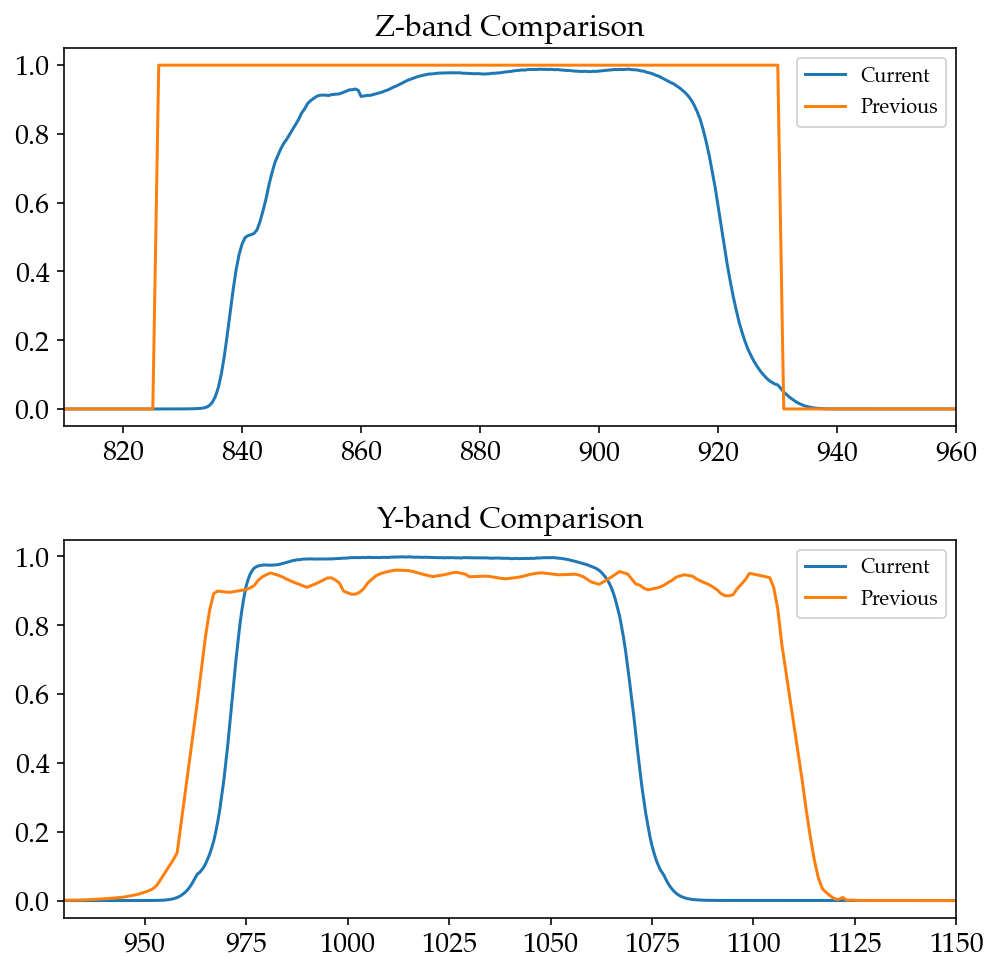

In [37]:
#pl.plot(Filters[0],Filters[2])

fig, ax = pl.subplots(2,1,figsize=(8,8))
pre_filer = pd.read_csv("files/custom_filter_ext.dat",comment="#",header=None,delim_whitespace=True)
fig.subplots_adjust(hspace=0.3)

ax[0].plot(Filters[0],Filters[1],label="Current")
ax[0].plot(pre_filer[0],pre_filer[4],label="Previous")
ax[0].set_xlim(810,960)
ax[0].legend()
ax[0].set_title("Z-band Comparison")

ax[1].plot(Filters[0],Filters[2],label="Current")
ax[1].plot(pre_filer[0],pre_filer[1],label="Previous")
ax[1].set_xlim(930,1150)
ax[1].legend()
ax[1].set_title("Y-band Comparison")

pl.show()